In [40]:
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict


from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore


from dotenv import load_dotenv
import os
from langchain.document_loaders import TextLoader
import numpy as np
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor # for parallelizing research


In [41]:
load_dotenv(override=True)  # This will load environment variables from .env file

True

In [42]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large") ## why?
vector_store = InMemoryVectorStore(embeddings) # why?
llm = ChatOpenAI(model="gpt-4o-mini") # why?

In [43]:
with open("onboarding/charlesRiverInterview.txt", "r", encoding="utf-8") as file:
    text = file.read()
    qa_pairs = text.split("\n\n")


In [44]:
all_splits = [Document(page_content=qa, metadata={"source": "onboarding/charlesRiverInterview.txt"}) for qa in qa_pairs]
print(len(all_splits))

39


In [45]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

In [66]:
prompt = hub.pull("rlm/rag-prompt")

# Define state for application
class State(TypedDict):
    desiredInformation: List[str]
    question: str
    context: List[Document]
    answer: str

def research(state: State):
    prompt = f"You are a helpful assistant preparing to answer the following question: {state['question']}. Generate a list of information about the user that asked the question that would help you to answer their question accurately. Return the list as a newline-separated string."
    response = llm.invoke(prompt)
    return {"desiredInformation": response.content.split("\n")}

def retrieve(state: State, minRelevance = 0.2, numStdDev = 2, showDistribution = False):
    def getMostRelevant(raw_results):
        scores = np.array([cosine_similarity for _, cosine_similarity in raw_results])
        print(len(raw_results))
        if showDistribution:
            plt.hist(scores)
            plt.show()
        mean = np.mean(scores)
        std = np.std(scores)
        return [raw_results[i][0] for i in np.where(scores >= mean + (std*numStdDev))[0] if raw_results[i][1] >= minRelevance]
    desiredInformation = state["desiredInformation"]
    docs = {}
    for info in desiredInformation:
        relevant = getMostRelevant(vector_store.similarity_search_with_score(info, k = len(all_splits)))
        for doc in relevant:
            docs[doc.id] = doc
    return {"context": list(docs.values())}

def generate(state: State):
    print("state['context']", state["context"])
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [67]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([research, retrieve, generate])
graph_builder.add_edge(START, "research")
graph_builder.add_edge("research", "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph = graph_builder.compile()


In [68]:
question = "Given your knowledge of where I'd like to go, and the plan we've agreed upon, what should I be doing on a daily basis?"
state =graph.invoke({"question": question})
print(state["answer"])

39
39
39
39
39
39
39
39
39
39
state['context'] [Document(id='70931dda-33a8-4259-a8b5-eb3bf87f3b23', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='What would success look like to you in the short and long term?\nShort term: Improved efficiency, achieving measurable progress toward my goals, and maintaining work-life balance.\nLong term: Leaving a meaningful legacy, both professionally and personally, while living a fulfilling, purpose-driven life.'), Document(id='f49b6a3c-0630-4146-9d31-7f11d4efd98a', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='How often would you like us to meet or check in?\nA biweekly check-in would be ideal, with flexibility for more frequent meetings during critical periods.\n'), Document(id='b8a32140-ab1c-44f1-9c93-2703bf6bd830', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='What steps are you currently taking to achieve these goals?\nI’ve been setting clearer priorities, dele

39


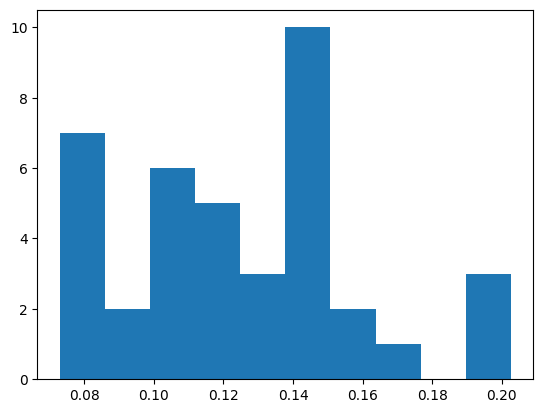

39


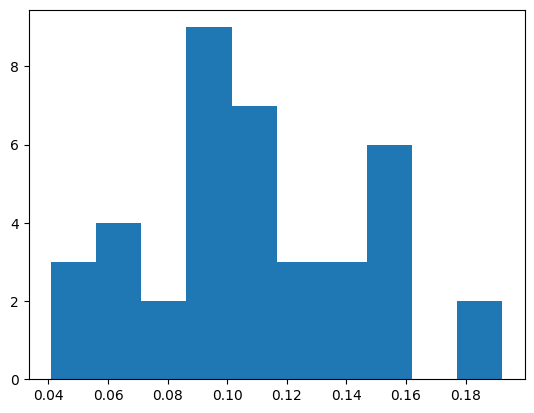

39


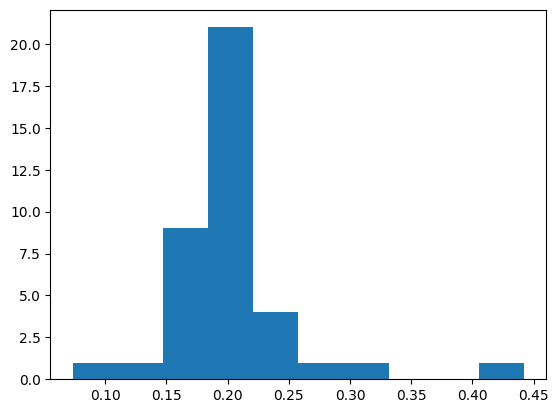

39


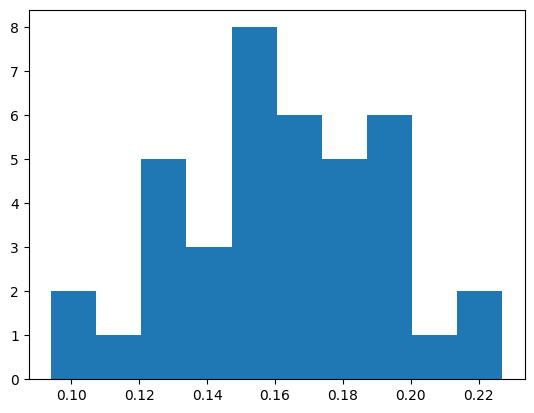

39


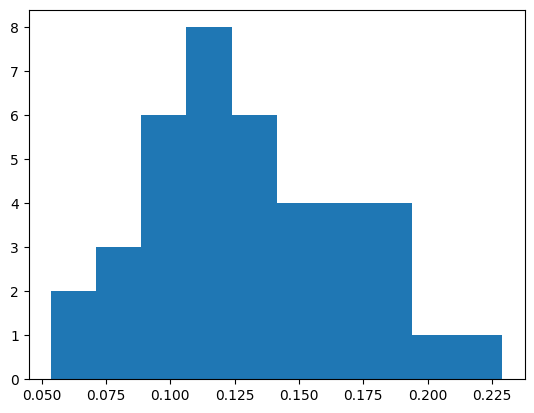

39


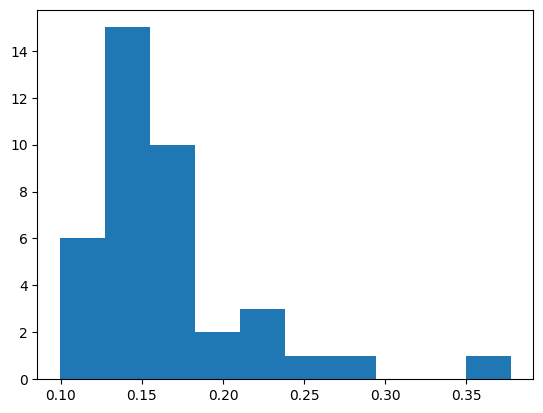

39


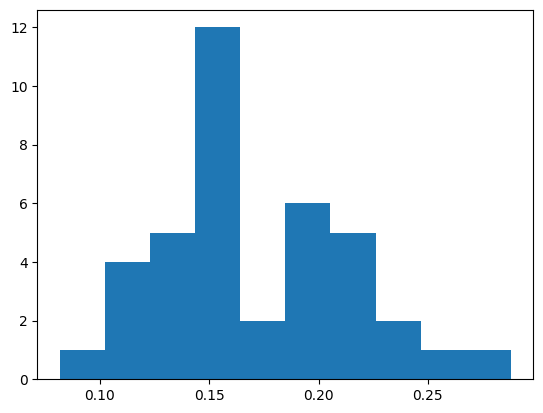

state['context'] [Document(id='0d398d46-e7ee-412a-a10c-1279dacd81f7', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='How do you typically communicate with others—professionally and personally?\nProfessionally, I’m direct and solutions-focused, ensuring clarity and respect. Personally, I aim to be empathetic and open while maintaining honesty.'), Document(id='76846d0b-d547-4c8d-8145-52d63813bb03', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='What are your hobbies or interests outside of work/study?\nI enjoy hiking, woodworking, and reading about history and philosophy.'), Document(id='3b75f75b-26e0-443f-95c2-3b096d4a55c1', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='What brought you here today?\nI’ve reached a point in life where I want to align my personal goals with my professional journey and need someone sharp to provide clarity and strategy.'), Document(id='a3b0ac91-31ff-4f86-b036-9be2223755a4'

{'desiredInformation': ["- The user's familiarity with idioms and expressions.",
  '- The context in which the user is asking about the phrase "curiosity killed the cat."',
  "- The user's interests or hobbies that might relate to the theme of curiosity.",
  "- The user's current project or topic of discussion to understand the relevance of the phrase.",
  "- The user's age or background, as it might influence their understanding of the phrase.",
  "- The user's preferred language or communication style.",
  "- The user's previous experiences or knowledge about curiosity and its implications."],
 'question': 'this has nothing to do with the project, curiousity killed the cat',
 'context': [Document(id='0d398d46-e7ee-412a-a10c-1279dacd81f7', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='How do you typically communicate with others—professionally and personally?\nProfessionally, I’m direct and solutions-focused, ensuring clarity and respect. Personally, I aim

In [61]:
graph.invoke({"question": "this has nothing to do with the project, curiousity killed the cat"})

39


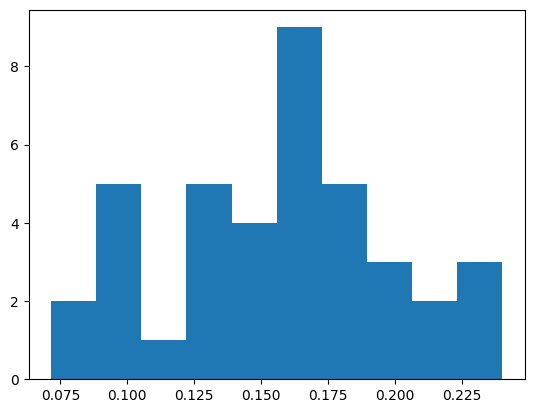

39


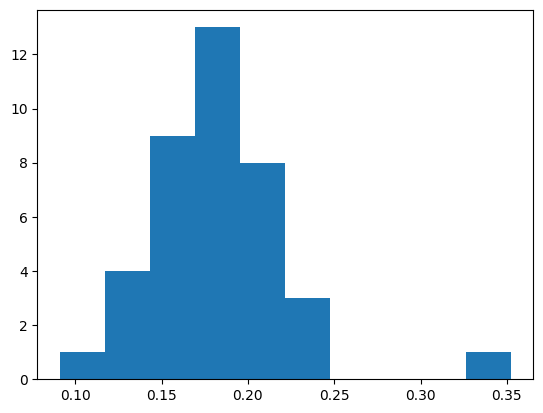

39


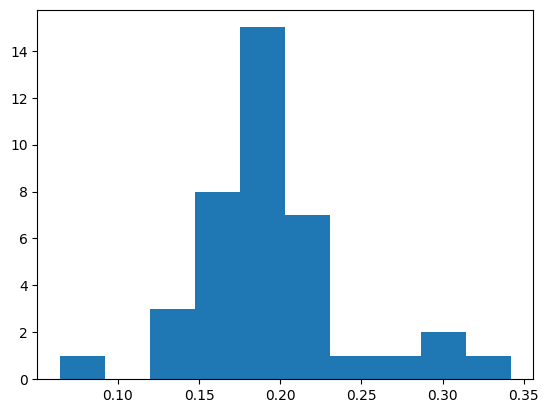

39


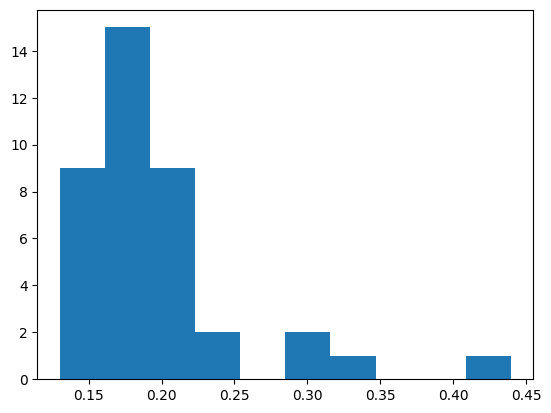

39


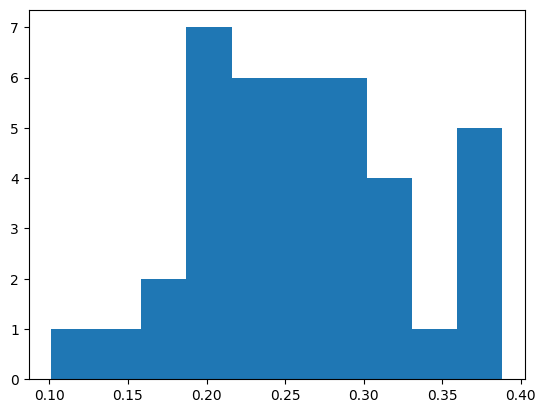

39


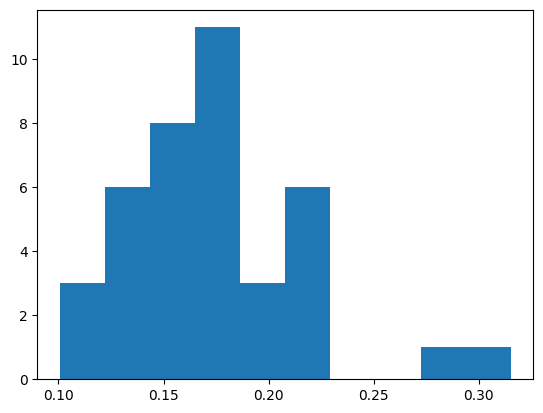

39


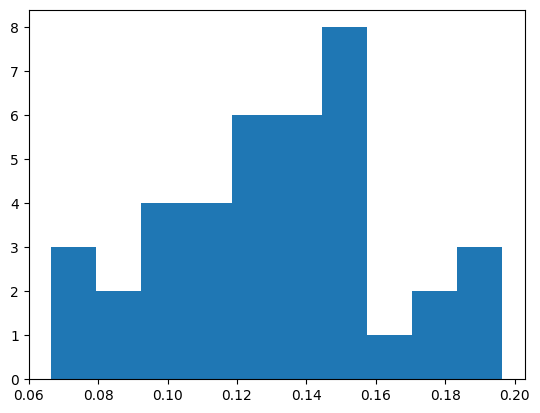

39


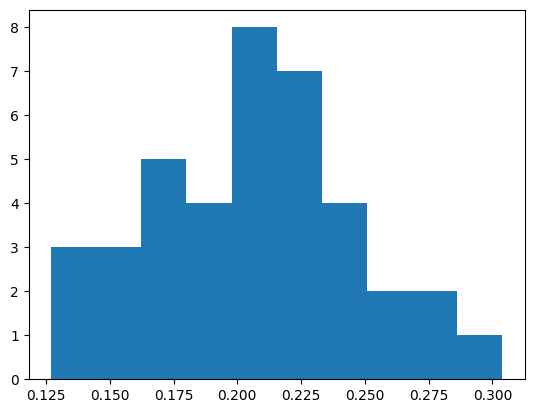

39


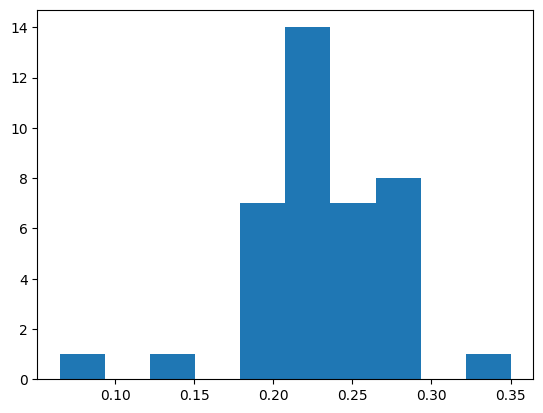

state['context'] [Document(id='76846d0b-d547-4c8d-8145-52d63813bb03', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='What are your hobbies or interests outside of work/study?\nI enjoy hiking, woodworking, and reading about history and philosophy.'), Document(id='b7afeefa-9457-4224-a112-b8ae71dbbad0', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='What strategies or support systems have you used in the past to overcome challenges?\nSeeking advice from mentors, breaking down goals into manageable steps, and leaning on a trusted team for support have been effective strategies.'), Document(id='c17d2d6f-b8ae-4332-b366-89064b9fe743', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='Have you noticed any recurring patterns in the difficulties you encounter?\nYes, I often take on too much responsibility and hesitate to delegate, which can lead to burnout or slowed progress.'), Document(id='0d398d46-e7ee-412a-a10c-

{'desiredInformation': ["- User's level of expertise in the subject matter",
  "- User's interests related to the question",
  "- User's previous experience with similar projects",
  "- User's preferred style of communication (formal, informal, etc.)",
  "- User's specific goals or objectives in relation to the question",
  "- User's background or profession",
  "- User's familiarity with idiomatic expressions or phrases",
  "- User's context for asking the question (e.g., casual conversation, academic inquiry, etc.)",
  "- User's attitude toward curiosity and exploration of topics outside their main focus"],
 'question': 'this has nothing to do with the project, curiousity killed the cat',
 'context': [Document(id='76846d0b-d547-4c8d-8145-52d63813bb03', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='What are your hobbies or interests outside of work/study?\nI enjoy hiking, woodworking, and reading about history and philosophy.'),
  Document(id='b7afeefa-945

In [62]:
graph.invoke({"question": "this has nothing to do with the project, curiousity killed the cat"})

39


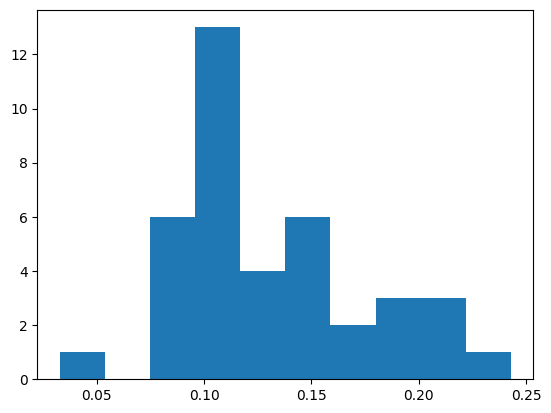

39


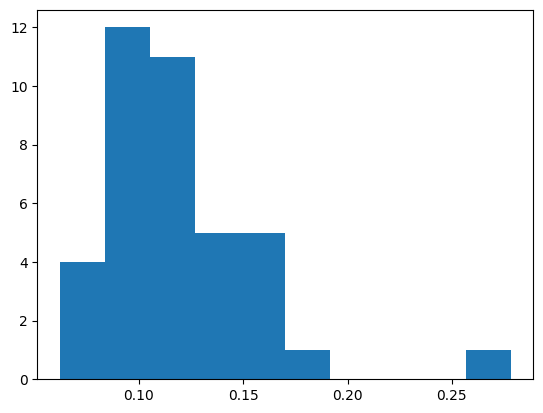

39


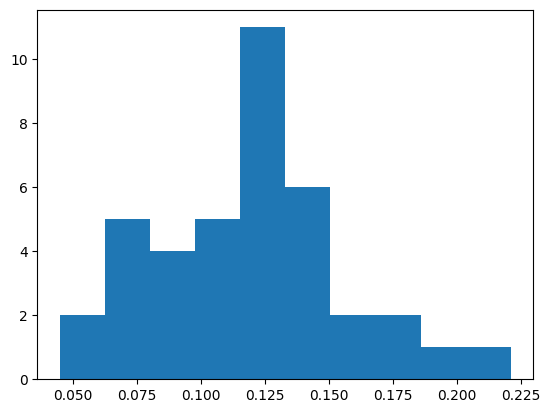

39


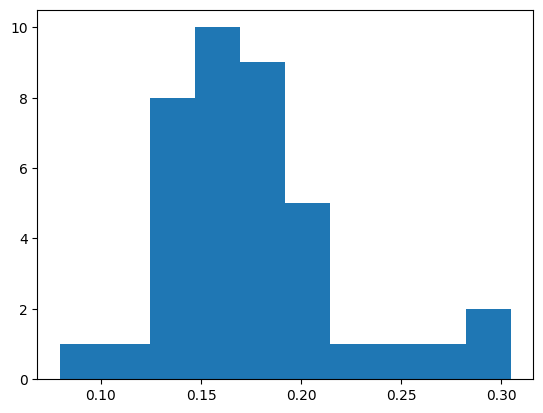

39


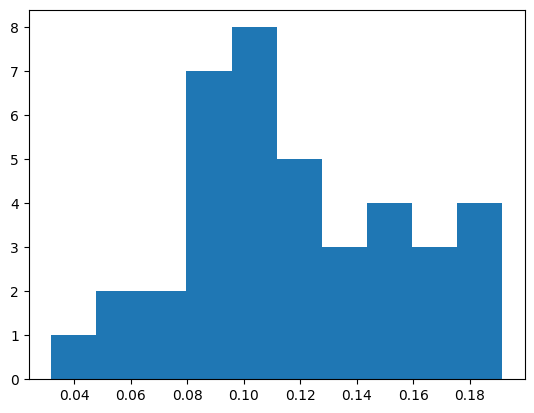

39


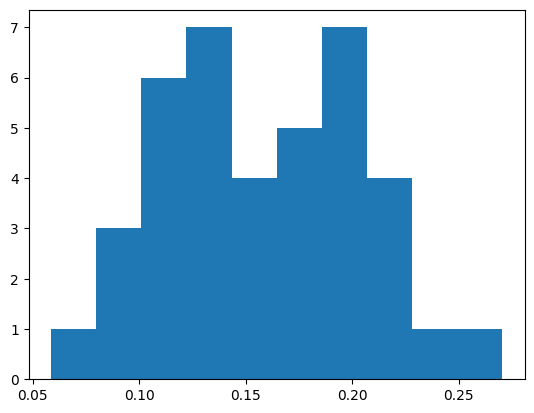

39


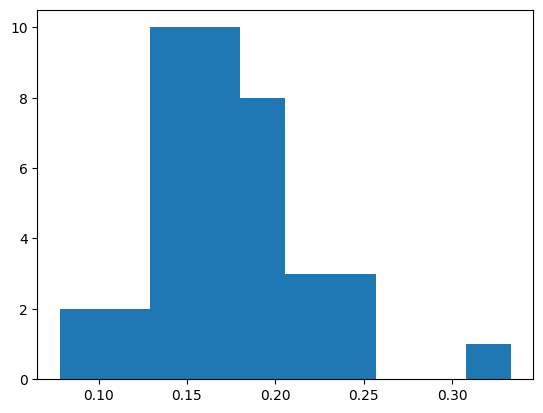

39


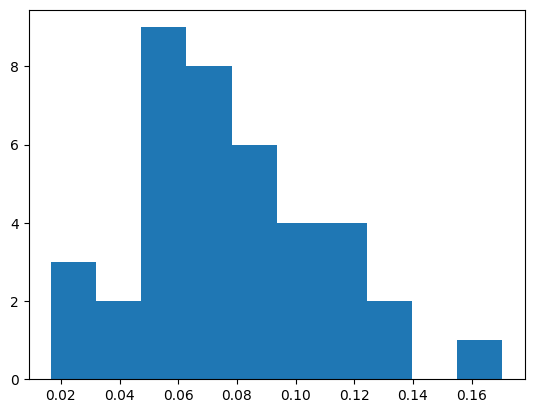

state['context'] [Document(id='dc5a7b05-4efd-4e27-89ac-6c34156008de', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='Is there anything else about yourself you’d like me to know upfront?\nI value efficiency and honesty. I don’t shy away from tough conversations, and I expect the same in return.'), Document(id='76846d0b-d547-4c8d-8145-52d63813bb03', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='What are your hobbies or interests outside of work/study?\nI enjoy hiking, woodworking, and reading about history and philosophy.'), Document(id='0d398d46-e7ee-412a-a10c-1279dacd81f7', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='How do you typically communicate with others—professionally and personally?\nProfessionally, I’m direct and solutions-focused, ensuring clarity and respect. Personally, I aim to be empathetic and open while maintaining honesty.'), Document(id='58eb7b27-054d-465e-9d7d-38a8d96c469c', meta

{'desiredInformation': ["- The user's sense of humor and preference for jokes or puns.",
  "- The user's interest in animals, particularly donkeys and parrots.",
  "- The user's familiarity with bar-related jokes or anecdotes.",
  "- The user's preferred style of storytelling (e.g., whimsical, absurd, straightforward).",
  "- The user's age or cultural background, which might influence their understanding of humor.",
  "- The user's expectations for the punchline or outcome of the scenario.",
  "- The user's interest in creative writing or storytelling.",
  "- The user's familiarity with common tropes or clichés in jokes involving animals."],
 'question': 'A donkey and a parrot walked into a bar. What happens next?',
 'context': [Document(id='dc5a7b05-4efd-4e27-89ac-6c34156008de', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='Is there anything else about yourself you’d like me to know upfront?\nI value efficiency and honesty. I don’t shy away from tough con

In [63]:
graph.invoke({"question": "A donkey and a parrot walked into a bar. What happens next?"})

39


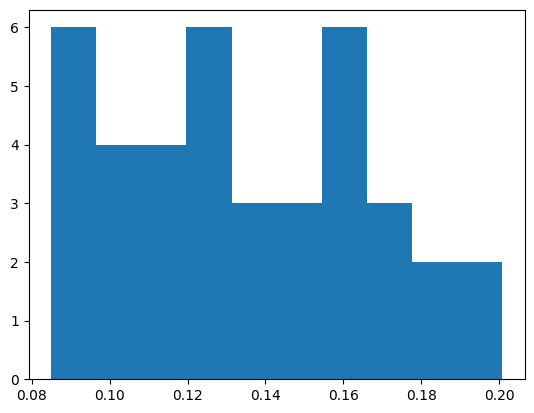

39


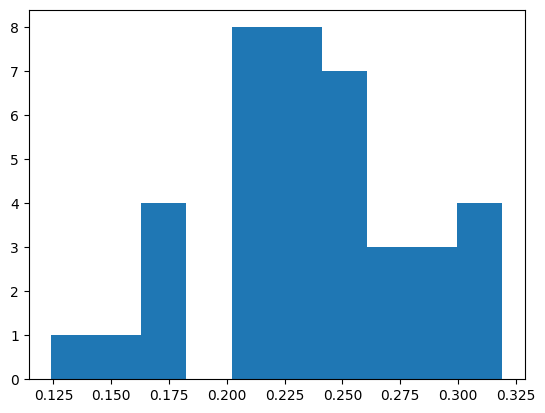

39


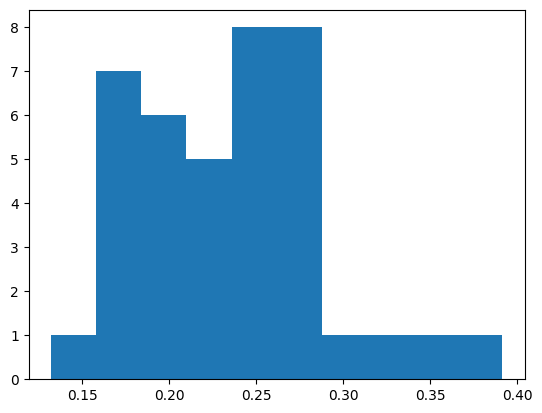

39


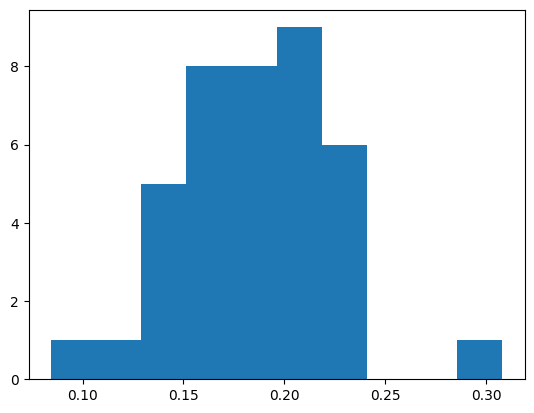

39


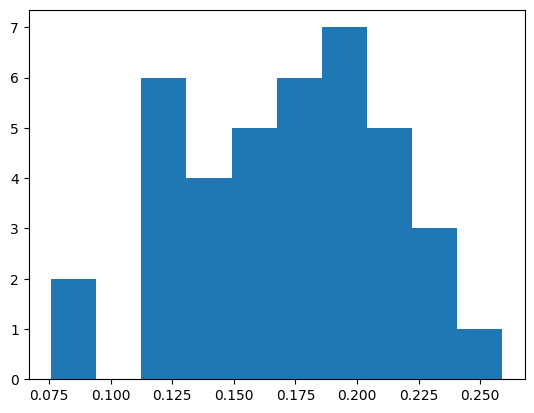

39


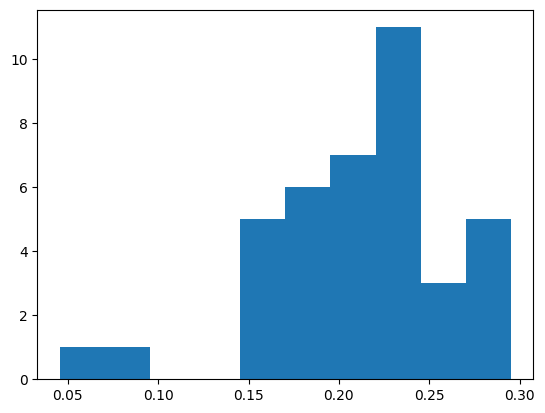

39


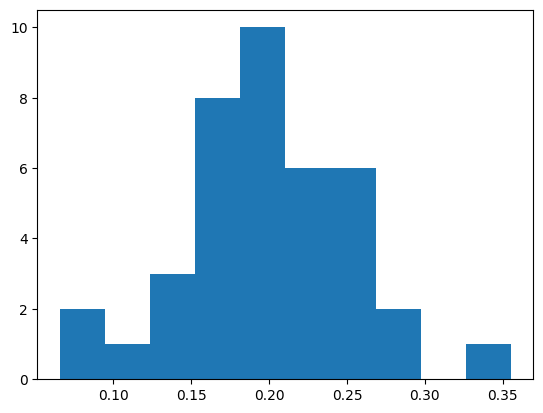

39


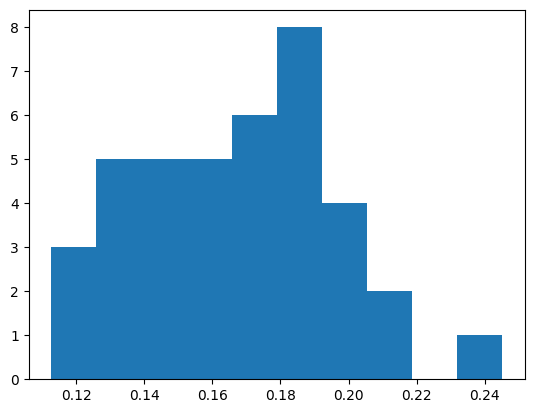

39


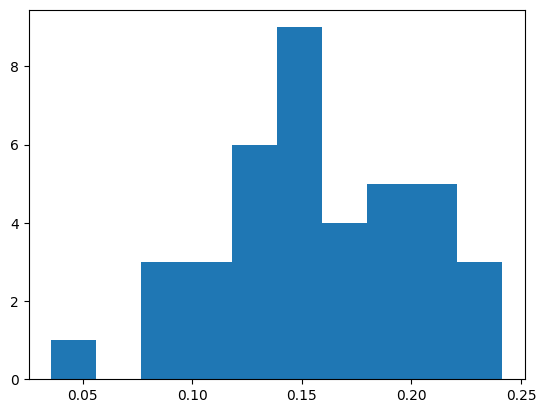

state['context'] [Document(id='8f3c2604-f055-4021-9c0f-3f55e77b0831', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='How would you describe yourself in three words?\nDriven, analytical, dependable.'), Document(id='0de75930-4a61-4365-b587-6b3e942d4b37', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='What do you do for work/study? How did you get into it?\nI’m a business owner in a specialized consulting field. I got into it after realizing I could merge my technical expertise with a passion for problem-solving and leadership.'), Document(id='afd81df8-3be3-4135-b10b-939a572a9d48', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='How satisfied are you with your overall well-being (physical, mental, emotional)?\nI’d rate it as good but with room for improvement—particularly in maintaining emotional balance during high-pressure situations.'), Document(id='58eb7b27-054d-465e-9d7d-38a8d96c469c', metadata={'sourc

{'desiredInformation': ["- The user's familiarity with artificial intelligence and machine learning concepts.",
  "- The user's specific interest in Arize AI (e.g., product features, use cases, company background).",
  "- The user's professional background (e.g., are they a data scientist, engineer, business analyst?).",
  "- The user's intended application or industry (e.g., finance, healthcare, technology).",
  "- The user's level of expertise in model monitoring and observability.",
  "- The user's interest in specific functionalities (e.g., model performance tracking, data validation).",
  "- The user's preferred learning style (e.g., detailed technical explanations, high-level summaries).",
  "- The user's geographical location, if relevant to the context of the question (e.g., regional AI trends).",
  "- The user's familiarity with competing platforms or tools for model monitoring."],
 'question': 'I am very interested in Arize AI. Tell me more about what they do.',
 'context': [

In [64]:
graph.invoke({"question": "I am very interested in Arize AI. Tell me more about what they do."})

39


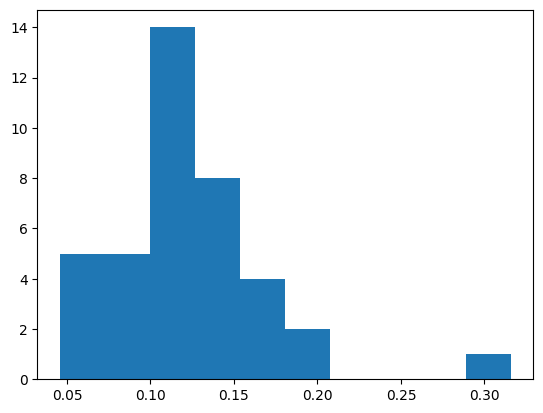

39


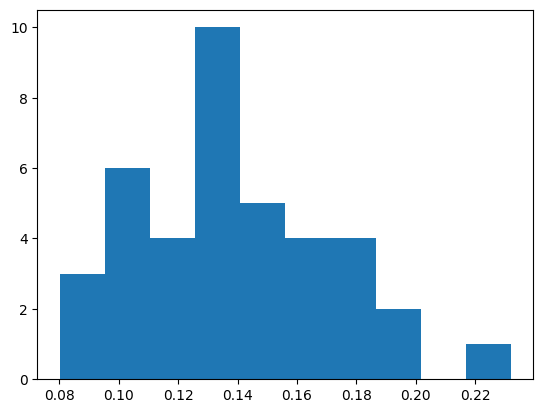

39


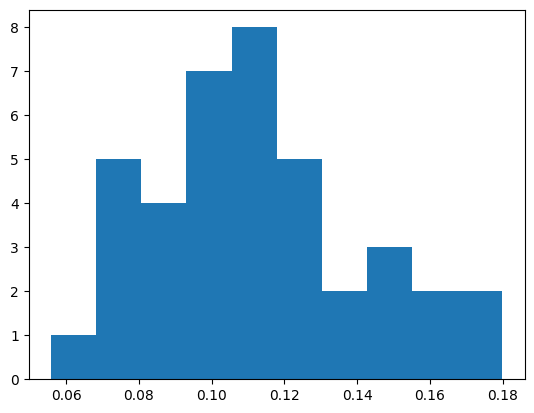

39


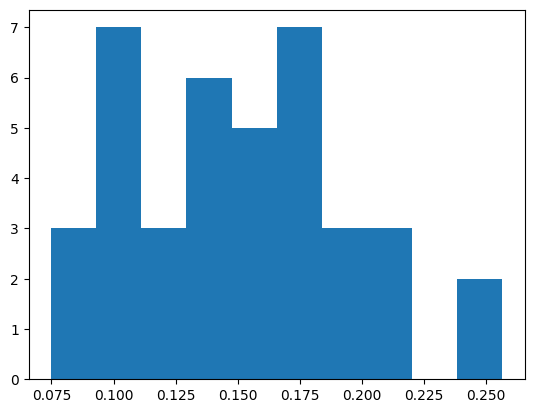

39


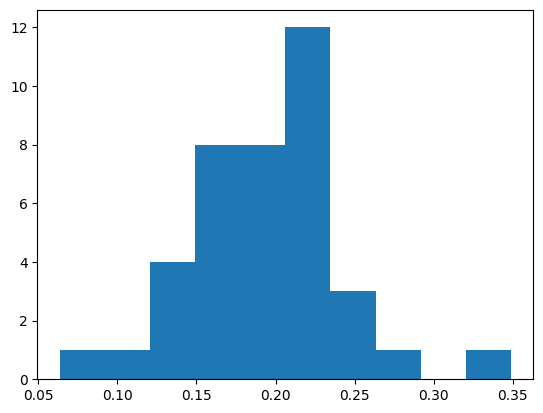

39


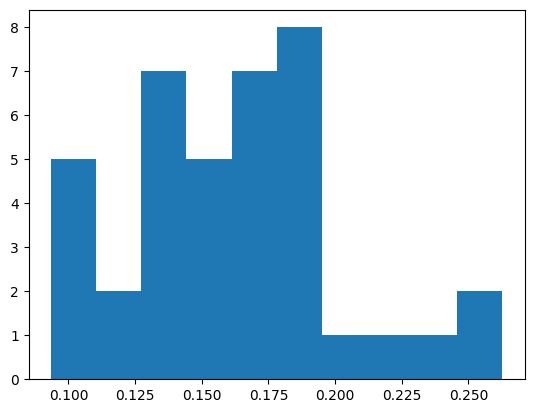

state['context'] [Document(id='a3b0ac91-31ff-4f86-b036-9be2223755a4', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='How old are you?\nI’m 47 years old.'), Document(id='2b7ab53c-33e0-4daa-b421-b1f70561ba93', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='Where did you grow up?\nI grew up in a small town in the Midwest, where community and hard work were central values.'), Document(id='dc5a7b05-4efd-4e27-89ac-6c34156008de', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='Is there anything else about yourself you’d like me to know upfront?\nI value efficiency and honesty. I don’t shy away from tough conversations, and I expect the same in return.'), Document(id='58eb7b27-054d-465e-9d7d-38a8d96c469c', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='How do you like to receive feedback or advice (e.g., direct, collaborative)?\nI prefer direct feedback, but I value a collaborative ap

{'desiredInformation': ['- Age range (e.g., teenager, adult)',
  '- Cultural background or location (as it may influence their understanding of milkshakes)',
  '- Familiarity with slang or pop culture references (e.g., familiarity with the song "Milkshake" by Kelis)',
  '- Dietary preferences or restrictions (e.g., vegan, lactose intolerant)',
  '- Interest in culinary topics or beverages',
  '- Purpose of the question (e.g., seeking a definition, looking for recipes, or understanding the cultural reference)'],
 'question': 'my milkshake brings all the boys to the yard. What is a milkshake?',
 'context': [Document(id='a3b0ac91-31ff-4f86-b036-9be2223755a4', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='How old are you?\nI’m 47 years old.'),
  Document(id='2b7ab53c-33e0-4daa-b421-b1f70561ba93', metadata={'source': 'onboarding/charlesRiverInterview.txt'}, page_content='Where did you grow up?\nI grew up in a small town in the Midwest, where community and hard w

In [65]:
graph.invoke({"question": "my milkshake brings all the boys to the yard. What is a milkshake?"})